In [9]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Actor Model 정의
class Actor(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(Actor, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_size),
            nn.Softmax(dim=-1)
        )

    def forward(self, state):
        return self.network(state)

# Critic Model 정의
class CriticV(nn.Module):
    def __init__(self, state_size, hidden_size):
        super(CriticV, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        return self.network(state)

# A2C Agent 정의
class A2CAgent:
    def __init__(self, env, state_size, action_size, hidden_size):
        self.env = env
        self.actor = Actor(state_size, action_size, hidden_size)
        self.critic = CriticV(state_size, hidden_size)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=7e-3)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=7e-3)
        self.gamma = 0.99

    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float).unsqueeze(0)
        probs = self.actor(state)
        action = torch.multinomial(probs, 1).item()
        return action

    def n_step_td_target(self, rewards, next_state, done):
        R_to_Go = self.critic(torch.tensor(next_state, dtype=torch.float)).item() * (1 - done)
        discounted_rewards = []
        for r in reversed(rewards):
            R_to_Go = r + self.gamma * R_to_Go
            discounted_rewards.insert(0, R_to_Go)
        return discounted_rewards

    def train_step(self, states, actions, discnt_rewards):
        states = torch.tensor(states, dtype=torch.float)
        actions = torch.tensor(actions, dtype=torch.int64)
        discnt_rewards = torch.tensor(discnt_rewards, dtype=torch.float)

        curr_Qs = self.critic(states).squeeze()
        curr_Ps = self.actor(states)
        log_probs = torch.log(curr_Ps.gather(1, actions.unsqueeze(-1)).squeeze())

        critic_loss = nn.MSELoss()(curr_Qs, discnt_rewards)
        actor_loss = -(log_probs * (discnt_rewards - curr_Qs.detach())).mean()

        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()

        actor_loss.backward()
        critic_loss.backward()

        self.actor_optimizer.step()
        self.critic_optimizer.step()

        return actor_loss.item(), critic_loss.item()

# 환경 및 에이전트 설정
env_name = "CartPole-v0"
env = gym.make(env_name)
env.seed(1234)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
hidden_size = 64
max_episodes = 300
agent = A2CAgent(env, state_size, action_size, hidden_size)

# 학습 루프
torch.manual_seed(336699)
scores = []
actor_losses = []
critic_losses = []

progress_bar = tqdm(range(max_episodes), desc="Training Progress")

for episode in progress_bar:
    state = env.reset()
    episode_reward = 0
    done = False

    states = []
    actions = []
    rewards = []
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state
        episode_reward += reward

        if done:
            scores.append(episode_reward)
            discnt_rewards = agent.n_step_td_target(rewards, next_state, done)
            actor_loss, critic_loss = agent.train_step(states, actions, discnt_rewards)
            progress_bar.set_postfix({'Episode': episode + 1, 'Reward': episode_reward, 'Actor Loss': actor_loss, 'Critic Loss': critic_loss})
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            break


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` i

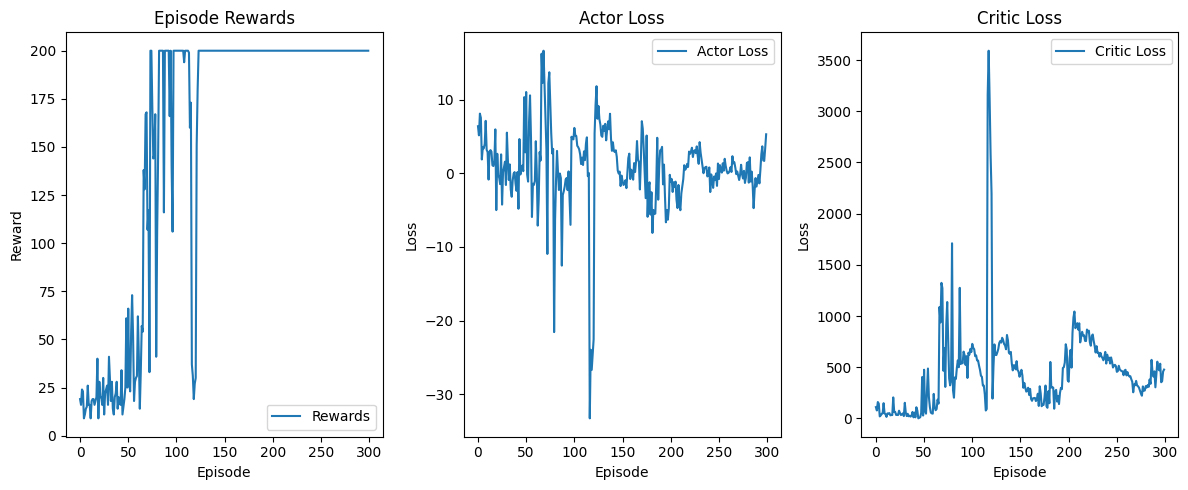

In [10]:
import matplotlib.pyplot as plt


# 그래프 그리기
plt.figure(figsize=(12, 5))

# 에피소드별 보상
plt.subplot(1, 3, 1)
plt.plot(scores, label='Rewards')
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()

# 에피소드별 배우(Actor) 손실
plt.subplot(1, 3, 2)
plt.plot(actor_losses, label='Actor Loss')
plt.title("Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()

# 에피소드별 평가자(Critic) 손실
plt.subplot(1, 3, 3)
plt.plot(critic_losses, label='Critic Loss')
plt.title("Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
scores

[17.0,
 18.0,
 21.0,
 20.0,
 16.0,
 22.0,
 41.0,
 17.0,
 16.0,
 8.0,
 17.0,
 20.0,
 14.0,
 47.0,
 22.0,
 13.0,
 18.0,
 9.0,
 17.0,
 51.0,
 21.0,
 23.0,
 13.0,
 56.0,
 21.0,
 41.0,
 34.0,
 59.0,
 15.0,
 28.0,
 75.0,
 17.0,
 20.0,
 19.0,
 11.0,
 26.0,
 14.0,
 57.0,
 50.0,
 18.0,
 37.0,
 38.0,
 41.0,
 26.0,
 49.0,
 30.0,
 39.0,
 75.0,
 62.0,
 22.0,
 19.0,
 55.0,
 92.0,
 36.0,
 33.0,
 122.0,
 53.0,
 61.0,
 90.0,
 102.0,
 59.0,
 82.0,
 69.0,
 33.0,
 67.0,
 53.0,
 54.0,
 93.0,
 121.0,
 73.0,
 57.0,
 56.0,
 56.0,
 92.0,
 37.0,
 101.0,
 94.0,
 122.0,
 104.0,
 91.0,
 200.0,
 200.0,
 200.0,
 200.0,
 164.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 200.0,
 145.0,
 84.0,
 151.0,
 200.0,
 200.0,
 200.0,
 200.0,
 168.0,
 128.0,
 124.0,
 52.0,
 132.0,
 133.0,
 126.0,
 164.0,
 153.0,
 182.0,
 191.0,
 162.0,
 182.0,
 168.0,
 153.0,
 200.0,
 160.0,
 200.0,
 169.0,
 165.0,
 179.0,
 200.0,
 200.0,
 194.0,
 190.0,
 193.0,
 171.0,
 179.0,
 185.0,
 179.0,
 164.0,
 153.0,
 142.0,
 134.0